## Notebook for Hard MoE implementation  
## 1. Set-up and Data Loading  
This is identical across all MoE implementations 

In [1]:
## Imports
import os
import sys
import time
from collections import defaultdict

import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
# setting device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [3]:
# Define the transformation to convert to Tensor and flatten it
flatten_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten()) # Flattens the C x H x W tensor to a 1D vector
])

DATA_DIR = "../data"

# Download and load the training dataset with the new transformation
train_dataset = datasets.MNIST(
    root = DATA_DIR,
    train = True,
    transform = flatten_transform,
    download = True
)

# Download and load the test dataset with the new transformation
test_dataset = datasets.MNIST(
    root = DATA_DIR,
    train = False,
    transform = flatten_transform,
    download = True
)

In [4]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
# Get the first image and its label from the training dataset
first_image, first_label = train_dataset[0]

# Print the shape of the image tensor
print(f"Shape of the first image: {first_image.shape}")
print(f"Label of the first image: {first_label}")

Number of training samples: 60000
Number of test samples: 10000
Shape of the first image: torch.Size([784])
Label of the first image: 5


In [5]:
## Set hyperparameters
BATCH_SIZE = 128

## Making data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_size = test_dataset.data.shape[0]
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_dataset_size, shuffle=True)

## 2. HardMoE implementation

In [6]:
class OneLayerExpert(torch.nn.Module):
    """Simple expert with only one hidden layer"""
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Hidden layer
        self.l_1 = torch.nn.Linear(input_size, hidden_size)
        self.relu_1 = torch.nn.ReLU()
        
        self.output = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu_1(self.l_1(x))
        x = self.output(x)
        return x

#the gating network. Here we only want the topk to contribute to the final output
class Gating(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, topk=2):
        super().__init__()
        self.l_1 = torch.nn.Linear(input_size, hidden_size)
        self.relu_1 = torch.nn.ReLU()
        self.output = torch.nn.Linear(hidden_size, output_size)
        self.topk = topk

    def forward(self, x):
        x = self.relu_1(self.l_1(x))
        x = self.output(x)
        '''This is the main difference between a soft MoE and HardMoE and this will cause problems with backpropagation
        since the gradient will be zero for all experts that are not in the topk'''
        if self.topk < x.shape[1]:
            # Get the top-k values
            topk_values, _ = torch.topk(x, self.topk, dim=1)
            # Get the k-th largest value for each sample
            threshold = topk_values[:, -1].unsqueeze(1) 
            # Set values below threshold to -inf
            x = torch.where(x >= threshold, x, torch.tensor(float('-inf')).to(x.device)) 
        # Apply softmax through expert/output dimension, so we get probability distribution but it will be over the topk experts
        x = F.softmax(x, dim=-1) 
        return x

class HardMOE(torch.nn.Module):
    def __init__(self, input_size, hidden_size_experts, hidden_size_gating, num_experts, output_size, topk):
        super().__init__()
        # Creating gating layer
        self.gate = Gating(
            input_size = input_size, 
            hidden_size = hidden_size_gating, 
            output_size = num_experts,
            topk = topk
        )
        # Create experts
        self.experts = nn.ModuleList(
            [OneLayerExpert(
                input_size=input_size, 
                hidden_size = hidden_size_experts, 
                output_size = output_size
            ) for _ in range(num_experts)]
        )

    def forward(self, x):
        # if B = batch_size, N = expert_num, D_out = expert output dimension
        gating_output = self.gate(x) # shape: (B, N)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2) # shape: (B, D_out, N)
        # Calculating weighted sum:
        # 1. gating_output.unsqueeze -> (B, N, 1)
        # 2. torch.bmm(...) -> (B, D_out, 1)
        # 3. .squeeze(2) -> (B, D_out)
        output = torch.bmm(expert_outputs, gating_output.unsqueeze(2)).squeeze(2)
        
        return output, gating_output

## 3. Training  
### 3.1 Set up

In [10]:
def calculate_accuracy(outputs, labels):
    _, output_index = torch.max(outputs, 1)
    return (output_index == labels).sum().item() / labels.size(0)

#training loop is largely unchanged, except we also store the gating outputs to calculate expert utilization
#and I will look at the gradients to see how training is done
def training_loop(train_loader, test_loader, num_epochs, model, loss_function, optimizer):
    model = model.to(DEVICE)
    # Metrics
    training_loss = []
    training_accuracy = []
    test_loss = []
    test_accuracy = []
    expert_utilization_history = []
    
    print("Starting the Training Loop")
    for epoch in range(num_epochs):
        model.train()
        batch_loss = []
        batch_accuracy = []
        epoch_gating_outputs = [] 
        
        # Loop through batches (Training Phase)
        for _, (data, label) in enumerate(train_loader):
            data = data.to(DEVICE)
            label = label.to(DEVICE)
            
            # Forward pass
            outputs, gating_output = model(data)
            epoch_gating_outputs.append(gating_output.detach().cpu())
            #print("gating ouputs: ", gating_output)
            # Evaluate
            loss = loss_function(outputs, label)
            batch_loss.append(loss.item())
            batch_accuracy.append(calculate_accuracy(outputs.detach(), label.detach()))
            
            # Backward pass setting gradients to zero
            optimizer.zero_grad()
            loss.backward()
            #we can see that some experts will have zero gradients and will not learn anything
            # for name, param in model.named_parameters():
            #     if torch.all(param.grad == 0):
            #         print(f"{name} has 0 gradient and is of shape {param.shape}")
            #     else:
            #         print(f"{name} has gradient and is of shape {param.shape}: ", param.grad)
            optimizer.step()

        # Combine all gating outputs from the epoch into a single tensor
        all_gating_outputs = torch.cat(epoch_gating_outputs, dim=0) # list of (B, N) tensors -> (Total Samples, N)
        # Calculate the average utilization for each expert over the entire training set
        avg_expert_utilization = all_gating_outputs.mean(dim=0).numpy() # (Total Samples, N) -> (N,)
                
        # Aggregate batch matrics
        training_accuracy.append(np.average(batch_accuracy))
        training_loss.append(np.average(batch_loss))
        expert_utilization_history.append(avg_expert_utilization)

        # Test Phase
        model.eval()
        test_loss_list = []
        test_accuracy_list = []
        
        with torch.no_grad():
            for _, (data, label) in enumerate(test_loader):
                data = data.to(DEVICE)
                label = label.to(DEVICE)
                
                # Forward pass
                test_predictions, _ = model(data)
                
                # Evaluate
                loss = loss_function(test_predictions, label) 
                test_loss_list.append(loss.item())
                
                # Use .detach() for metric calculation
                test_accuracy_list.append(calculate_accuracy(test_predictions.detach(), label.detach())) 

        # Aggregate batch matrics
        test_loss.append(np.average(test_loss_list))
        test_accuracy.append(np.average(test_accuracy_list))
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} done. Test loss {test_loss[-1]:.4f}. Test accuracy {test_accuracy[-1]:.4f}")
    
    return training_loss, training_accuracy, test_loss, test_accuracy, expert_utilization_history

In [11]:
LEARNING_RATE = 0.0001
EPOCHS = 100

EXPERT_NUM = 8
MNIST_LINEAR_LENGTH = 784  # Input
MNIST_CLASS_NUM = 10       # Output
EXPERT_HIDDEN_SIZE = 25 
GATING_HIDDEN_SIZE = 10
TOP_K = 2

moe = HardMOE(
    input_size=MNIST_LINEAR_LENGTH,
    hidden_size_experts=EXPERT_HIDDEN_SIZE,
    hidden_size_gating=GATING_HIDDEN_SIZE,
    num_experts=EXPERT_NUM,
    output_size=MNIST_CLASS_NUM,
    topk=TOP_K
)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(moe.parameters(), lr=LEARNING_RATE)

In [12]:
training_start = time.time()

training_loss, training_accuracy, test_loss, test_accuracy, expert_utilization_history = \
    training_loop(
        train_loader=train_loader, 
        test_loader=test_loader, 
        num_epochs=EPOCHS, 
        model=moe, 
        loss_function=loss, 
        optimizer=optimizer)

training_end = time.time()
training_duration = training_end-training_start

Starting the Training Loop
Epoch: 0 done. Test loss 2.2956. Test accuracy 0.1411
Epoch: 10 done. Test loss 2.2570. Test accuracy 0.2768
Epoch: 20 done. Test loss 2.2127. Test accuracy 0.3549
Epoch: 30 done. Test loss 2.1629. Test accuracy 0.4188
Epoch: 40 done. Test loss 2.1082. Test accuracy 0.4980
Epoch: 50 done. Test loss 2.0471. Test accuracy 0.5698
Epoch: 60 done. Test loss 1.9794. Test accuracy 0.6184
Epoch: 70 done. Test loss 1.9048. Test accuracy 0.6535
Epoch: 80 done. Test loss 1.8239. Test accuracy 0.6801
Epoch: 90 done. Test loss 1.7353. Test accuracy 0.7011


In [13]:
# Training test plot curve code that was provided in assignment 1 to get the plots
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, training_time, epochs):
    """Plots the train-test cost and accuracy curve"""
    lg=18
    md=13
    sm=9
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    
    ## Add subtitle with hyperparameters and training time
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training Time:{round(training_time)}sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    
    x = range(1, len(train_costs)+1)
    
    ## Cost/Loss subplot
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    #axs[0].set_yscale('log') # Optionally use a logarithmic y-scale
    
    ## Accuracy subplot
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    
    
def plot_utilization_histogram(
    epochs_to_plot: list[int],
    utilization_data: dict[int, np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (12, 4)
):
    """Creates a series of bar plots showing expert utilization for specified epochs."""
    num_epochs = len(epochs_to_plot)

    if num_epochs == 0:
        print("No epochs to plot.")
        return

    # Use a single row layout for simplicity
    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_epochs,
        figsize=(figsize[0], figsize[1]),
        sharey=True # Share the y-axis (0-1 range)
    )

    # If there is only one subplot, axes is not an array, so make it one
    if num_epochs == 1:
        axes = [axes]

    # Determine expert names if not provided
    first_epoch_data = utilization_data[epochs_to_plot[0]]
    num_experts = len(first_epoch_data)
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    x = np.arange(num_experts) # the label locations
    width = 0.8 # the width of the bars

    for ax, epoch in zip(axes, epochs_to_plot):
        utilization = utilization_data.get(epoch)

        if utilization is None:
            print(f"Warning: No data found for epoch {epoch}. Skipping.")
            continue

        # Create the bar plot
        ax.bar(x, utilization, width, color='skyblue', edgecolor='black')

        # Set title and labels
        ax.set_title(f'Epoch {epoch}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(expert_names, rotation=45, ha='right')
        ax.set_ylim(0, 1.0) # Set the y-limit from 0 to 1 as requested
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        # Only set y-label on the first subplot
        if ax == axes[0]:
            ax.set_ylabel('Average Utilization (0 to 1)', fontsize=10)

        # Add utilization values on top of the bars
        for i, val in enumerate(utilization):
            ax.text(x[i], val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle('Expert Utilization Across Epochs', y=1.02, fontsize=14, fontweight='bold')
    #plt.savefig('expert_utilization_plot.png')
    plt.close(fig)


def plot_utilization_trends(
    epochs_to_plot: list[int],
    utilization_data: dict[int, np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (10, 6)
):
    """Creates a line/scatterplot showing the utilization trend of each expert across the specified epochs."""
    if not epochs_to_plot:
        print("No epochs to plot.")
        return

    # Filter and sort epochs for which we have data
    valid_epochs = sorted([e for e in epochs_to_plot if e in utilization_data])

    if not valid_epochs:
        print("No valid utilization data found for the specified epochs.")
        return

    # Collect all utilization arrays in valid epoch order
    all_utilizations = [utilization_data[e] for e in valid_epochs]

    # Stack them vertically (rows are epochs, columns are experts)
    utilization_matrix = np.vstack(all_utilizations)

    # Transpose to get (rows are experts, columns are epochs)
    expert_utilization_trends = utilization_matrix.T

    num_experts = expert_utilization_trends.shape[0]

    # Determine expert names if not provided
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]
    elif len(expert_names) != num_experts:
        print(f"Warning: Expert names list length ({len(expert_names)}) does not match number of experts ({num_experts}). Using default names.")
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    fig, ax = plt.subplots(figsize=figsize)

    for i in range(num_experts):
        expert_data = expert_utilization_trends[i]
        expert_name = expert_names[i]

        # Plot line and scatter points
        ax.plot(valid_epochs, expert_data, label=expert_name, marker='o', linestyle='-')

    ax.set_title('Expert Utilization Trends Across Epochs', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Average Utilization (0 to 1)', fontsize=12)

    # Set x-ticks to be only the plotted epoch numbers
    ax.set_xticks(valid_epochs)

    # Ensure y-axis is from 0 to 1
    ax.set_ylim(0, 1.0)

    # Add legend
    ax.legend(title="Experts", loc='best', fontsize=10)

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    #plt.savefig('expert_utilization_trends.png')
    plt.close(fig)
    
    import numpy as np
import matplotlib.pyplot as plt

def plot_utilization_histogram(
    epochs_to_plot: list[int],
    utilization_data: list[np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (12, 4)
):
    """Creates a series of bar plots showing expert utilization for specified epochs."""
    num_epochs = len(epochs_to_plot)
    # Get used data from overall utilization history
    utilization_data = [utilization_data[i] for i in epochs_to_plot]

    if num_epochs == 0:
        print("No epochs to plot.")
        return

    # Check for data consistency
    if len(utilization_data) != num_epochs:
        print(f"Error: Number of epochs to plot ({num_epochs}) does not match number of utilization data arrays ({len(utilization_data)}).")
        return

    # Use a single row layout for simplicity
    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_epochs,
        figsize=(figsize[0], figsize[1]),
        sharey=True # Share the y-axis (0-1 range)
    )

    # If there is only one subplot, axes is not an array, so make it one
    if num_epochs == 1:
        axes = np.array([axes]) # Use np.array for consistent iteration

    # Determine expert names if not provided
    first_epoch_data = utilization_data[0]
    num_experts = len(first_epoch_data)
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    x = np.arange(num_experts) # the label locations
    width = 0.8 # the width of the bars

    for ax, epoch, utilization in zip(axes, epochs_to_plot, utilization_data):
        # The utilization data is now directly available, no dict.get() needed
        if utilization is None: # Should not happen if data is well-formed, but good check
            print(f"Warning: Data for epoch {epoch} is None. Skipping.")
            continue

        # Create the bar plot
        ax.bar(x, utilization, width, color='skyblue', edgecolor='black')

        # Set title and labels
        ax.set_title(f'Epoch {epoch}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(expert_names, rotation=45, ha='right')
        ax.set_ylim(0, 1.0) # Set the y-limit from 0 to 1 as requested
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        # Only set y-label on the first subplot (axes[0] is the first one)
        if ax == axes[0]:
            ax.set_ylabel('Average Utilization (0 to 1)', fontsize=10)

        # Add utilization values on top of the bars
        for i, val in enumerate(utilization):
            ax.text(x[i], val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle('Expert Utilization Across Epochs', y=1.02, fontsize=14, fontweight='bold')
    plt.show()


def plot_utilization_trends(
    utilization_data: list[np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (10, 6)
):
    """Creates a line/scatterplot showing the utilization trend of each expert across the epochs."""
    
    num_epochs = len(utilization_data)

    # Stack them vertically (rows are epochs, columns are experts)
    # The epochs in valid_epochs now correspond to the rows in the matrix
    utilization_matrix = np.vstack(utilization_data)

    # Transpose to get (rows are experts, columns are epochs)
    expert_utilization_trends = utilization_matrix.T

    num_experts = expert_utilization_trends.shape[0]
    
    # Determine expert names if not provided
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]
    elif len(expert_names) != num_experts:
        print(f"Warning: Expert names list length ({len(expert_names)}) does not match number of experts ({num_experts}). Using default names.")
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    fig, ax = plt.subplots(figsize=figsize)

    for i in range(num_experts):
        expert_data = expert_utilization_trends[i]
        expert_name = expert_names[i]

        # Plot line and scatter points
        ax.plot(range(num_epochs), expert_data, label=expert_name, marker='o', linestyle='-')

    ax.set_title('Expert Utilization Trends Across Epochs', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Average Utilization (0 to 1)', fontsize=12)

    # Set x-ticks to be only the plotted epoch numbers
    ax.set_xticks(range(0, num_epochs, 20))

    # Ensure y-axis is from 0 to 1
    ax.set_ylim(0, 1.0)

    # Add legend
    ax.legend(title="Experts", loc='best', fontsize=10)

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

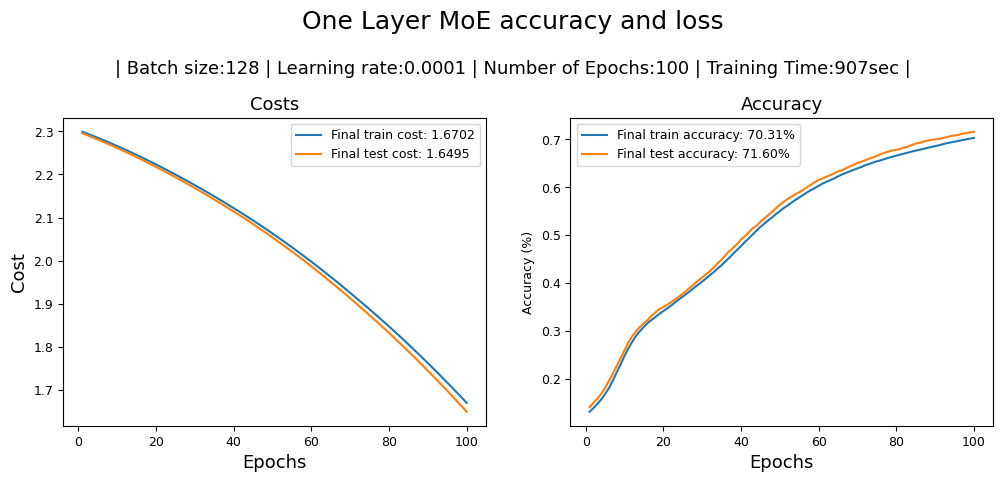

In [14]:
training_curve_plot(
    title="One Layer MoE accuracy and loss", 
    train_costs=training_loss, 
    test_costs=test_loss, 
    train_accuracy=training_accuracy, 
    test_accuracy=test_accuracy, 
    batch_size=BATCH_SIZE, 
    learning_rate=LEARNING_RATE, 
    training_time=training_duration, 
    epochs=EPOCHS)

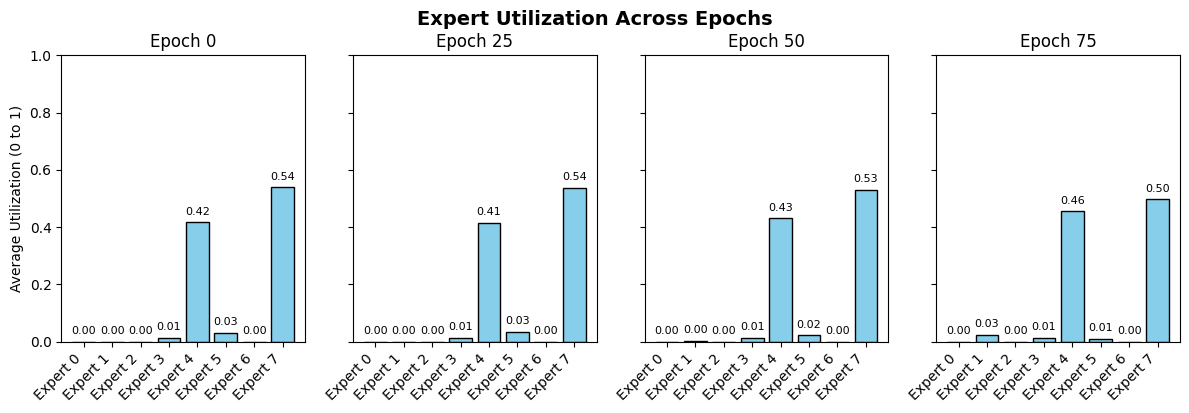

In [15]:
plot_utilization_histogram(
    epochs_to_plot=[0, 25, 50, 75], 
    utilization_data=expert_utilization_history
)

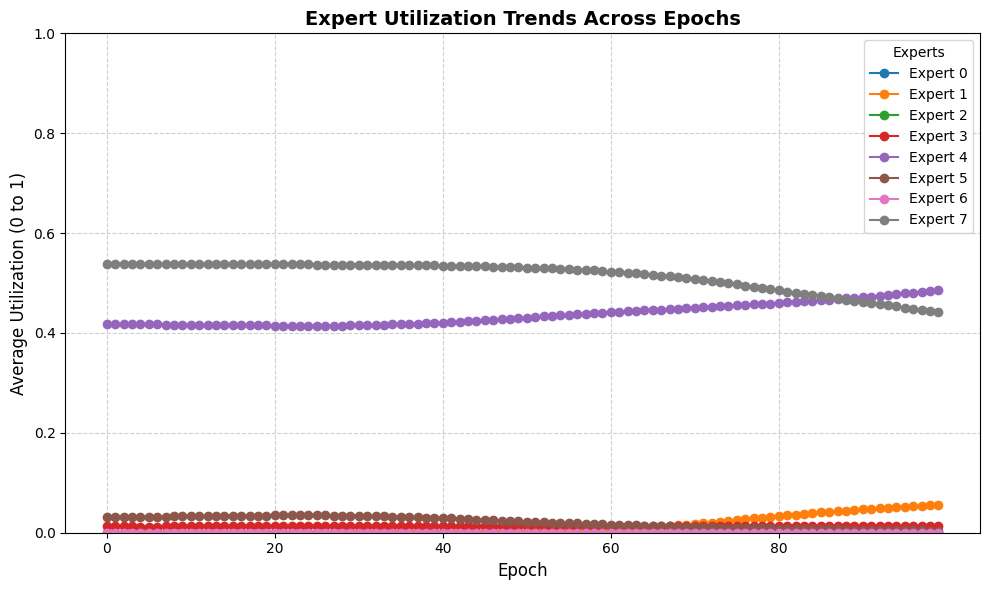

In [16]:
plot_utilization_trends(utilization_data=expert_utilization_history)

## 4 Evaluation  
### 4.1 Set up

In [18]:
moe.eval()

# Access model parameters and nodes
for name, param in moe.named_parameters():
    print(name, param.shape)
#This will not work because this is a HardMoE model so we cut out part of the model with gating topk
#print(get_graph_node_names(moe))

gate.l_1.weight torch.Size([10, 784])
gate.l_1.bias torch.Size([10])
gate.output.weight torch.Size([8, 10])
gate.output.bias torch.Size([8])
experts.0.l_1.weight torch.Size([25, 784])
experts.0.l_1.bias torch.Size([25])
experts.0.output.weight torch.Size([10, 25])
experts.0.output.bias torch.Size([10])
experts.1.l_1.weight torch.Size([25, 784])
experts.1.l_1.bias torch.Size([25])
experts.1.output.weight torch.Size([10, 25])
experts.1.output.bias torch.Size([10])
experts.2.l_1.weight torch.Size([25, 784])
experts.2.l_1.bias torch.Size([25])
experts.2.output.weight torch.Size([10, 25])
experts.2.output.bias torch.Size([10])
experts.3.l_1.weight torch.Size([25, 784])
experts.3.l_1.bias torch.Size([25])
experts.3.output.weight torch.Size([10, 25])
experts.3.output.bias torch.Size([10])
experts.4.l_1.weight torch.Size([25, 784])
experts.4.l_1.bias torch.Size([25])
experts.4.output.weight torch.Size([10, 25])
experts.4.output.bias torch.Size([10])
experts.5.l_1.weight torch.Size([25, 784])
e

In [ ]:
# For getting the probability distribution for experts
#this again doesn't really work with HardMoE because of the topk
return_nodes = {
    "gate.softmax" : "probs"
}

# Getting the gating network
moe_gating = create_feature_extractor(moe, return_nodes=return_nodes)
moe_gating.eval()

TraceError: symbolically traced variables cannot be used as inputs to control flow